In [1]:
import pandas as pd
import re 
import nltk 
import sqlite3
import numpy as np
import ast
import string 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import Data

In [2]:
conn = sqlite3.connect('lowva\lowva.db')
conn.text_factory = str
cur = conn.cursor()

In [3]:
dfnotes=pd.read_sql_query('''select * from notes''', conn)
dfnotes["enc_date"]=pd.to_datetime(dfnotes["enc_date"])

In [4]:
dfnotes.head()
len(dfnotes)

,pat_deid,note_deid,enc_date,note,note_desc
0,1174,28528746.0,2009-01-12,"January 12, 2009 Peter R Egbert, MD R...",Outpatient Letter
1,1174,28528751.0,2009-01-12,Department of Ophthalmology California Vitreo...,RTF Letter
2,1174,58842312.0,2009-09-17,Assessment and Plan: 1. Proliferative diabeti...,Progress Notes
3,1790,174426007.0,2012-02-14,Retina Service Outpatient Encounter Steven ...,Progress Notes
4,1790,174435847.0,2012-02-14,Retina Service Outpatient Encounter Steven ...,RTF Letter


67690

In [5]:
conn.close() 

# Directly preprocess full notes for CLAMP - Haiwen's Project

In [9]:
df=dfnotes[dfnotes["note_desc"]=="Progress Notes"]
df["note_deid"]=df["note_deid"].astype(int)

C:\Users\Sophia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
def get_note_length(text): 
    try: 
        return len(text)
    except TypeError: 
        return None 

In [32]:
df["note_length"]=df["note"].apply(get_note_length)

C:\Users\Sophia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

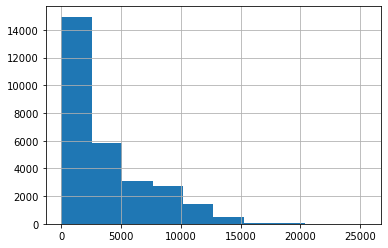

In [33]:
df["note_length"].hist()

In [35]:
#select longish notes at least 1000 characters 
df = df[df["note_length"]>=1000]

In [37]:
#two stage sampling. 
#one random note per patient, then one random row of that 
dfsample = df.groupby("pat_deid").sample(n=1, random_state=0).sample(1000, random_state=1)

In [38]:
dfsample

,pat_deid,note_deid,enc_date,note,note_desc,note_length
50280,2898571,598277351,2016-03-24,CC: referred for elevated intraocular pressure...,Progress Notes,5193.0
24585,1518694,59043385,2009-09-21,"I have done a complete, fourteen-point review ...",Progress Notes,1207.0
54035,3094044,100751229,2010-12-09,CLINICAL ELECTROPHYSIOLOGY READING: ERG # 2498...,Progress Notes,1403.0
38765,2247623,549000528,2015-11-05,HPI- 32 yo M with Down syndrome. First vi...,Progress Notes,4121.0
13281,853379,107154545,2011-02-08,OPHTHALMOLOGY - CORNEA CLINIC Patient ident...,Progress Notes,5398.0
...,...,...,...,...,...,...
30872,1834112,80616805,2010-05-26,Stanford University Hospital and Clinics Opht...,Progress Notes,9134.0
30211,1796120,217900295,2012-09-05,HPI- Patient presents for UCC appointment. R...,Progress Notes,3936.0
65698,3760494,74562153,2010-03-25,HPI- Referred by Dr. Ta. First visit to see...,Progress Notes,3298.0
31704,1866448,193126728,2012-04-03,Optical coherence tomography (OCT) INTERPRETAT...,Progress Notes,1786.0


In [39]:
len(dfsample["pat_deid"].unique())

1000

In [41]:
del dfsample["note_desc"]
del dfsample["note_length"]

In [43]:
dfsample.reset_index(inplace=True, drop=True)
dfsample.head()

,pat_deid,note_deid,enc_date,note
0,2898571,598277351,2016-03-24,CC: referred for elevated intraocular pressure...
1,1518694,59043385,2009-09-21,"I have done a complete, fourteen-point review ..."
2,3094044,100751229,2010-12-09,CLINICAL ELECTROPHYSIOLOGY READING: ERG # 2498...
3,2247623,549000528,2015-11-05,HPI- 32 yo M with Down syndrome. First vi...
4,853379,107154545,2011-02-08,OPHTHALMOLOGY - CORNEA CLINIC Patient ident...


In [53]:
for name, group in dfsample.groupby(dfsample.index):
        group.to_csv("C:/Users/Sophia/Documents/ResearchPHI/STRIDE_FULL/lowva/clampnotesample/" +
                     str(name).zfill(4)+'-pid'+str(group.iloc[0][0]) + '-nid' + str(group.iloc[0][1]) + '.txt', index=False, header=False)

# Alternative: Export for pre processing, section finding, laterality tagging before CLAMP

In [ ]:
#Save notes to CSV so that we can run Luisa's pre-processing step to it 

#but first we will run only a sample 
dfnotesample=dfnotes.head(50)
dfnotesample=dfnotesample[["note_deid", "note"]]

dfnotesample.to_csv("predictglaucsurgoutcomesample.csv", index=False)

In [ ]:
#and now we will output 
dfnotes.to_csv("lowvafullnotes.csv", index=False)

In [ ]:
#of note, preprocessing all of these notes takes about 26 minutes

## Import preprocessing results, create dataframe of note sections

In [ ]:
clampdf=pd.read_csv("output-preprocesslowva-allnotes.csv")
#clampdf=clampdf[["note_deid","note_cleaned"]]
clampdf.head()

In [ ]:
clampdf.dtypes
len(clampdf)

In [ ]:
#quick detour to save the output (minus useless variables) as a csv to upload for teammates 
savepreprocessoutput=clampdf[["note_deid", "note_cleaned", "dates", "sections"]]
savepreprocessoutput.to_csv("lowva-preprocess-output.csv", index=False)

In [ ]:
clampdfsection=clampdf[["note_deid", "sections"]]

In [ ]:
#create dataframe for each row
#this is super inefficient but i can't think of a vectorized way to do it 
#of note this takes less than 40 minutes 
column_names = ["note_deid", "section", "text"]
dfsection=pd.DataFrame(columns=column_names)

for i in range(len(clampdfsection)):
    note_deid = clampdfsection["note_deid"][i]
    sections=clampdfsection["sections"][i]
    interim = pd.DataFrame(columns = column_names)
    sectionlist=ast.literal_eval(sections) 
    for j in range(len(sectionlist)): 
        sectiondict=sectionlist[j]
        sectiondict["note_deid"]=note_deid
        interim.loc[j]=pd.Series(sectiondict)
    dfsection=pd.concat([dfsection, interim], axis=0)
dfsection.head()
dfsection.tail()
len(dfsection)

In [ ]:
#now slightly process the section headers
dfsection["section"]=dfsection["section"].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.strip()

In [ ]:
len(dfsection["section"].unique())

In [ ]:
sectionlist=list(dfsection["section"].unique())
sectionlist.sort()

In [ ]:
sectionlist

In [ ]:
def sectioncleanup(sectionheader): 
    if sectionheader.startswith('call'): 
        return "call"
    if sectionheader.startswith('active problem'):
        return "problem list"
    if sectionheader.startswith('allerg'):
        return "allergy"
    elif sectionheader.startswith('current  med') or sectionheader.startswith('current med') or sectionheader.startswith('current outpatient prescriptions') or sectionheader.startswith('meds'): 
        return 'current medications'
    elif sectionheader.startswith('exam') or sectionheader.startswith('physical exam') : 
        return 'exam'
    elif sectionheader.startswith('eye med') or sectionheader=="gtts" or sectionheader.startswith('ocular med'): 
        return 'eye medications'
    elif sectionheader.startswith('fam'): 
        return 'family history'
    elif sectionheader in ["hpi", "history of present illness"]:
        return 'hpi'
    elif sectionheader=='imp' or sectionheader=='impression' or sectionheader=='assessment': 
        return 'assessment'
    elif sectionheader.startswith('impression') or sectionheader.startswith('imp') or sectionheader.startswith('assessment') or sectionheader=='ip': 
        return 'ap'
    elif sectionheader.startswith('pmh') or sectionheader=="past medical history":
        return 'pmh'
    elif sectionheader.startswith('recommendation') or sectionheader=='plan' or sectionheader=='advised': 
        return 'plan'
    elif sectionheader.startswith('review of system') or sectionheader=='ros': 
        return 'ros'
    elif sectionheader.startswith('risk'): 
        return "risk"
    elif sectionheader.startswith('soc'): 
        return "social history"
    elif sectionheader in ['ophthalmic history', 'ocular history', 'ocular hx', 'past ocular hx', 'past ocular history']: 
        return 'ocular history'
    elif 'interpretation' in sectionheader: 
        return 'interpretation'
    elif 'instruct' in sectionheader: 
        return 'instruction'
    else: 
        return sectionheader 

In [ ]:
newsectionlist=set()
for word in sectionlist: 
    newsectionlist.add(sectioncleanup(word))
newsectionlist

In [ ]:
#now let's add a section header clean 
dfsection["sectionclean"]=dfsection["section"].apply(sectioncleanup)

In [ ]:
dfsection.head(20)

## Process notes for CLAMP - one line per txt file

In [ ]:
clampdfsection=dfsection[["note_deid", 'sectionclean', 'text']]
#we want to process this one row at a time so 
clampdfsection.reset_index(inplace=True, drop=True)
clampdfsection.head()

In [ ]:
len(clampdfsection)

for name, group in clampdfsection.groupby(clampdfsection.index): 
    print(group.iloc[0][0])
    print(group.iloc[0][1])
    print(group.iloc[0][2])

In [ ]:
for name, group in clampdfsection.groupby(clampdfsection.index):
        group.to_csv("C:/Users/Sophia/Documents/ClampWin_1.6.1/workspace/MyPipeline/clamp-ner/Data/InputLowVa/" +
                     str(name)+'-'+str(group.iloc[0][0]) + '-' + str(group.iloc[0][1]) + '.txt', index=False, header=False)

# Import CLAMP output and continue processing 
- this is a way to read in all the clamp output .txt files and combine them into one dataframe for later processing/input into DL models 
- will need to be updated for Haiwen's project most likely 
- Can also be modified to create jsonl files for import to Prodigy, I think. Or the XML files can be read instead, if easier to convert those to jsonl for Prodigy 

In [ ]:

#Column Headers
#Start End Semantic CUI Assertion Entity
#And add an note_deid and section column 
import glob 
import os 
import pandas as pd

path = r'C:/Users/Sophia/Documents/ClampWin_1.6.1/workspace/MyPipeline/clamp-ner/Data/Output' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    df = pd.read_csv(filename, sep = '\t', index_col=None, header=0)
    df['section'] = os.path.basename(filename).strip('.txt').translate(str.maketrans('', '', '0123456789-'))
    df['note_deid'] = os.path.basename(filename).strip('.txt').translate(str.maketrans('', '', 'abcdefghijklmnopqrstuvwxyz'))#Put in a new column with the filename 
    df['note_deid']=df['note_deid'].str.split('-').str.get(1)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
frame.head(26)

In [ ]:
frame["section"]=frame["section"].str.strip('.')

In [ ]:
frame.to_csv("lowva-clampoutput.csv", index=False)

In [ ]:
#frame["note_deid"]=pd.to_numeric(frame["note_deid"]).astype(int)